In [1]:
%matplotlib inline 
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from IPython import display
import random 
import matplotlib

# LOAD TRAINING DATA
train_mat = scipy.io.loadmat('data/mnist_data/images.mat')
train_images_raw = train_mat['images'].T
train_images_corrected = []
for i in range(len(train_images_raw)):
    train_images_corrected.append(train_images_raw[i].T.ravel())
train_images_corrected = np.array(train_images_corrected)
#Now let's try kmeans clusterings


In [3]:

# 1 reclassify
# 2 reset mean.

#A single iteration of reclassification.


def kmeans(data, k):
    mu = [np.random.rand(data[0].shape[0])*255/2.0 for i in range(k)]
    k_classes = [[] for i in range(k)]
    changed = True
    truth = [True for i in range(k)]
    while changed:


        for image in data:
            index, closest, dif  = 0, mu[0], 100000000000
            for i, mu_i in enumerate(mu):
                dist = np.linalg.norm(mu_i - image)
                if dist < dif:
                    index,closest,dif = i, mu_i, dist

            k_classes[index].append(image)


        for i in range(len(mu)):
            temp = np.mean(k_classes[i], axis=0)
            truth[i] = temp != mu[i]
            mu[i] = temp

        for val in truth:
            if val is True:
                changed = True
                break
            else:
                changed = False

    return mu, k_classes

Class 0 Count: 6608


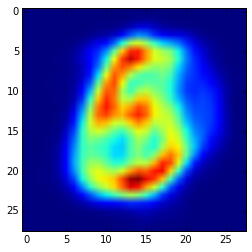

Class 1 Count: 10184


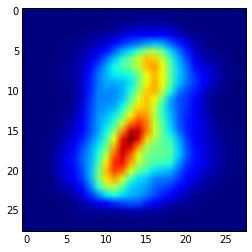

Class 2 Count: 3666


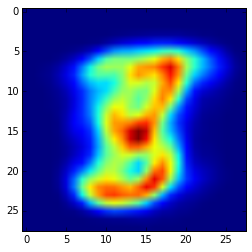

Class 3 Count: 724


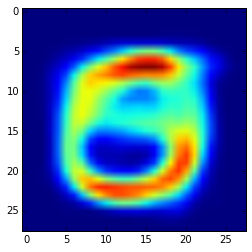

Class 4 Count: 37


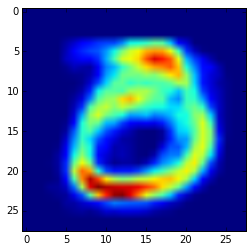

Class 5 Count: 20041


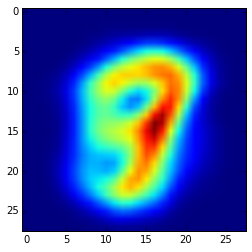

Class 6 Count: 3047


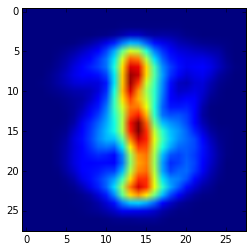

Class 7 Count: 6647


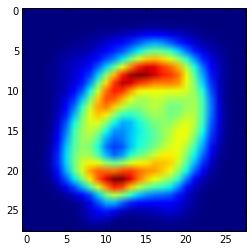

Class 8 Count: 5171


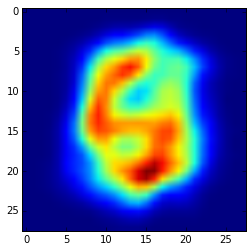

Class 9 Count: 3875


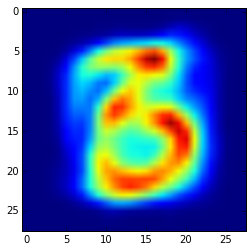

In [4]:
k = 10
mu, classes = kmeans(train_images_corrected, k)
for i in range(k):
    plt.imshow(mu[i].reshape(28,28))
    print("Class", i, "Count:", len(classes[i]))
    fuck = "class" + str(i);
    plt.savefig(fuck + ".png")
    plt.show()

# Joke Recommender System
First we'll need to load the data.

In [2]:
joke_train_mat = scipy.io.loadmat('./data/joke_data/joke_train.mat')
j_up_train = joke_train_mat['train']

#load validation set.
from numpy import genfromtxt
valid_data = genfromtxt('./data/joke_data/validation.txt', delimiter=',')
valid_data[valid_data == 0] = -1
valid_data = valid_data - np.array([0,1,0])


def loss(user, joke, actual, predictor):
    pred = predictor(user,joke)
    return np.sign(pred) != np.sign(actual)*1

def validate(predictor):
    net_error = 0
    for example in valid_data:
        net_error += loss(example[0], example[1], example[2], predictor)
    return net_error/len(valid_data)

In [3]:
# simple system. Get the average rating of a joke.
#copy the up_train
j_avg_train = np.array(j_up_train[:,:])
j_avg_train_nan_index = np.isnan(j_avg_train)
j_avg_train[j_avg_train_nan_index] = 0
j_score = np.mean(j_avg_train, axis=0)
#j_score is the joke score.

def lame_score(user, joke):
    return j_score[joke]

validate(lame_score)

0.3796747967479675

# k-Nearest Neighboors.
We do a k-nearest neighboors approach and take the average of those nearest neighboors. Supervised power in the aggreegate that is the crowd.

In [7]:
# First lets calculate the distance matrix on all of these dudes. :)
import scipy.spatial
j_dist_matrix = scipy.spatial.distance.pdist(j_avg_train, 'euclidean')

In [24]:
def get_k_classifier(k):
    print(k)
    cache = {}
    def knn_score(user, joke):
        # get k closest neighboors
        if user not in cache:
            cache[user] = np.argsort([j_dist_matrix[i*j] for j in range(len(j_avg_train))])
        
        neighbors = cache[user][:k]
        return np.mean(np.array(list(map(lambda i: j_avg_train[i][joke], neighbors))))

    return knn_score
    

In [29]:
ks = [10, 100, 1000]
error = []
for k in ks:
    error.append(validate(get_k_classifier(k)))
plt.plot(ks, error)

10
100
1000


# Latent Factor Model
We use the latent factor model on our data

In [4]:
# First let's try SVD on the 0 replaced matrix
U, s, V = np.linalg.svd(j_avg_train, full_matrices=False)

In [14]:

def j_avg_mse(U, S, V):
    pred = U.dot(S.dot(V))
    net = 0
    n= 0
    for i in range(j_up_train.shape[0]):
        for j in range(j_up_train.shape[1]):
            if not np.isnan(j_up_train[i,j]):
                net += (pred[i,j] - j_up_train[i,j])**2
                n += 1
                
    return net/n
    
    

2
5
10
20
100


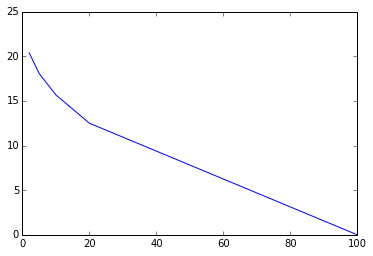

In [32]:
ds = [2,5,10,20,100]
error = []
for d in ds:
    print(d)
    S = np.diag(np.append(s[:d], np.zeros(len(s)-d)))
    error.append(j_avg_mse(U,S,V))
plt.plot(ds,error)

In [30]:
# Let's see our validation error.
def get_latent(d):
    S = np.diag(np.append(s[:d], np.zeros(len(s)-d)))
    Vprime = S.dot(V)
    def latent_classifier(user ,joke):
        return U[user].dot(Vprime.T[joke])
    return latent_classifier

[0.46693766937669379,
 0.43333333333333335,
 0.43685636856368565,
 0.45501355013550138,
 0.45718157181571817,
 0.46531165311653117,
 0.47588075880758807,
 0.50514905149051492]

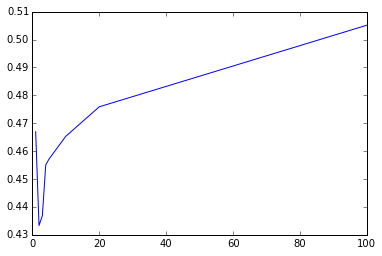

In [36]:
ds = [1,2,3,4,5,10,20,100]
error = []
for d in ds:
    error.append(validate(get_latent(d)))
plt.plot(ds,error)
error